In [14]:
# 导入所需的库
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# ------------------- 添加中文字体配置 ------------------- #
# 解决中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为黑体
plt.rcParams['axes.unicode_minus'] = False     # 解决负号显示异常
# ------------------------------------------------------ #


In [9]:


# 设置随机种子，以确保结果的可重复性
torch.manual_seed(0)

# 定义数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),  # 将图像转换为张量
    transforms.Normalize((0.1307,), (0.3081,))  # 标准化图像
])

# 加载MNIST数据集
train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)  # 训练数据集
test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)  # 测试数据集

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # 训练数据加载器
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)  # 测试数据加载器

# 定义神经网络模型（LeNet）
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return nn.functional.log_softmax(x, dim=1)

# 创建神经网络模型实例
model = Net()

# 定义优化器和损失函数
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

# 训练模型
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('训练 Epoch: {} [{}/{} ({:.0f}%)]\t损失: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

# 测试模型
def mytest():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\n测试集: 平均损失: {:.4f}, 准确率: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# 进行模型训练和测试
for epoch in range(1, 11):
    train(epoch)
    mytest()

训练 Epoch: 1 [0/60000 (0%)]	损失: 2.320024
训练 Epoch: 1 [6400/60000 (11%)]	损失: 0.577872
训练 Epoch: 1 [12800/60000 (21%)]	损失: 0.454696
训练 Epoch: 1 [19200/60000 (32%)]	损失: 0.279256
训练 Epoch: 1 [25600/60000 (43%)]	损失: 0.275145
训练 Epoch: 1 [32000/60000 (53%)]	损失: 0.114979
训练 Epoch: 1 [38400/60000 (64%)]	损失: 0.148121
训练 Epoch: 1 [44800/60000 (75%)]	损失: 0.089719
训练 Epoch: 1 [51200/60000 (85%)]	损失: 0.125886
训练 Epoch: 1 [57600/60000 (96%)]	损失: 0.062619

测试集: 平均损失: 0.0014, 准确率: 9729/10000 (97%)

训练 Epoch: 2 [0/60000 (0%)]	损失: 0.077855
训练 Epoch: 2 [6400/60000 (11%)]	损失: 0.175302
训练 Epoch: 2 [12800/60000 (21%)]	损失: 0.120275
训练 Epoch: 2 [19200/60000 (32%)]	损失: 0.038788
训练 Epoch: 2 [25600/60000 (43%)]	损失: 0.294706
训练 Epoch: 2 [32000/60000 (53%)]	损失: 0.023332
训练 Epoch: 2 [38400/60000 (64%)]	损失: 0.027906
训练 Epoch: 2 [44800/60000 (75%)]	损失: 0.081031
训练 Epoch: 2 [51200/60000 (85%)]	损失: 0.031003
训练 Epoch: 2 [57600/60000 (96%)]	损失: 0.082196

测试集: 平均损失: 0.0011, 准确率: 9774/10000 (98%)

训练 Epoch: 3 [0/60000 (0%)]

保存权重

将训练得到的权重保存在model.pth文件夹中

In [10]:
from torch.serialization import load
from torch.serialization import save  # 或直接使用 torch.save

# 假设 model 是已经训练好的模型
state_dict = model.state_dict()  # 获取模型权重（参数）
save(state_dict, "model.pth")     # 保存权重到文件

导出为ONNX格式

In [11]:
# 确保模型处于评估模式
model.eval()

# 创建虚拟输入
dummy_input = torch.randn(1, 1, 28, 28)

# 导出为ONNX
torch.onnx.export(
    model, dummy_input, "mnist_model.onnx",
    export_params=True,
    opset_version=11,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
)
print("模型已导出为ONNX格式: mnist_model.onnx")

# 导出为TorchScript (两种方法)
try:
    # 方法1: 跟踪
    traced_model = torch.jit.trace(model, dummy_input)
    traced_model.save("mnist_model_traced.pt")
    print("模型已导出为TorchScript (跟踪) 格式: mnist_model_traced.pt")
except Exception as e:
    print(f"跟踪导出失败: {e}")

try:
    # 方法2: 脚本化
    scripted_model = torch.jit.script(model)
    scripted_model.save("mnist_model_scripted.pt")
    print("模型已导出为TorchScript (脚本化) 格式: mnist_model_scripted.pt")
except Exception as e:
    print(f"脚本化导出失败: {e}")

模型已导出为ONNX格式: mnist_model.onnx
模型已导出为TorchScript (跟踪) 格式: mnist_model_traced.pt
模型已导出为TorchScript (脚本化) 格式: mnist_model_scripted.pt


测试

In [12]:
def predict_random_sample(model, dataset):
    """从数据集中随机选取一个样本，显示图片并输出预测结果"""
    model.eval()  # 确保模型处于评估模式
    index = random.randint(0, len(dataset) - 1)  # 随机生成索引
    data, target = dataset[index]  # 获取数据和真实标签
    
    # 预处理数据（添加批次维度）
    data = data.unsqueeze(0)  # 形状从 (1,28,28) 变为 (1,1,28,28)
    
    with torch.no_grad():
        output = model(data)
        pred = output.argmax(dim=1).item()  # 预测结果
        confidence = torch.exp(output)[0][pred].item() * 100  # 置信度（概率）
    
    # 显示原始图片
    plt.figure(figsize=(2, 2))
    plt.imshow(data.squeeze().numpy(), cmap='gray')  # 移除批次和通道维度
    plt.title(f"真实标签: {target}\n预测结果: {pred}\n置信度: {confidence:.1f}%")
    plt.axis('off')
    plt.show()
    
    return pred, target, confidence

---------------------- 随机样本预测 ----------------------


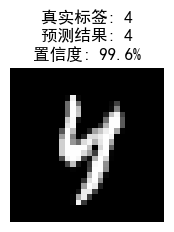

预测结果: 4 | 真实标签: 4 | 置信度: 99.6%


In [25]:
print("---------------------- 随机样本预测 ----------------------")
pred, target, confidence = predict_random_sample(model, test_dataset)
print(f"预测结果: {pred} | 真实标签: {target} | 置信度: {confidence:.1f}%")